In [2]:
!pip install pennylane

In [3]:
import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys

# Setting our constants
sys.path.append('..')

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [4]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy

--2026-01-06 07:02:54--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32896 (32K) [application/octet-stream]
Saving to: ‘train_X.npy’

train_X.npy         100%[===================>]  32.12K  --.-KB/s    in 0.002s  

2026-01-06 07:02:54 (13.2 MB/s) - ‘train_X.npy’ saved [32896/32896]

--2026-01-06 07:02:54--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256 [

In [5]:
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

In [9]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Inference (Model Prediction) - 기존 유지
# ==========================================
def get_predictions(model, inputs):
    """Run inference on inputs using the trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
    return predicted_labels.cpu().numpy()

def data_to_tensor(X, y):
    tensor_X = torch.tensor(X, dtype=torch.complex64)
    tensor_y = torch.tensor(y, dtype=torch.long)
    return tensor_X, tensor_y

t_train_X, t_train_y = data_to_tensor(train_X, train_y)
train_dataset = TensorDataset(t_train_X, t_train_y)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [85]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
import copy

# [설정]
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)
device = "cuda" if torch.cuda.is_available() else "cpu"

# ==========================================
# 1. Circuit: Sandwich Structure
# ==========================================
@qml.qnode(dev, interface='torch')
def circuit(state, params, final_rot_params):
    qml.StatePrep(state, wires=range(n_qubits))

    # Sandwich: 이웃 연결 - 이웃 연결 - 장거리 연결(4) - 이웃 연결 - 이웃 연결
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits), ranges=[1, 1, 4, 1, 1])

    # Final Rotation
    qml.Rot(*final_rot_params[0], wires=0)
    qml.Rot(*final_rot_params[1], wires=1)

    return qml.probs(wires=[0, 1])

# ==========================================
# 2. 모델 정의
# ==========================================
class QNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_layers = 5
        self.params = nn.Parameter(torch.randn(self.n_layers, n_qubits, 3) * 0.1)
        self.final_rot_params = nn.Parameter(torch.randn(2, 3) * 0.1)
        self.total_params = (self.n_layers * n_qubits * 3) + 6

    def forward(self, x):
        return circuit(x, self.params, self.final_rot_params)

# ==========================================
# 3. 학습 실행 (Loss 기준 저장)
# ==========================================
model = QNN()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.04)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300, eta_min=0.0001)

print(f"--- Training QNN (Loss Priority, Params: {model.total_params}) ---")

def quantum_phase_loss(probs, labels):
    probs = probs + 1e-8
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes=probs.shape[1])
    probs = probs / torch.sum(probs, dim=1, keepdim=True)
    loss = -torch.sum(label_one_hot * torch.log(probs), dim=1)
    return torch.mean(loss)

# 초기값 설정 (Loss는 낮을수록 좋으므로 무한대로 시작)
best_acc = 0.0
best_loss = float('inf')
best_model_state = None

if 'train_loader' in globals():
    for epoch in range(300):
        total_loss = 0
        correct = 0

        model.train()
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = quantum_phase_loss(predictions, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted_classes = torch.argmax(predictions, dim=1)
            correct += (predicted_classes == batch_y).sum().item()

        scheduler.step()

        avg_loss = total_loss / len(train_loader)
        avg_acc = correct / len(train_dataset)

        # [핵심 변경] 정확도가 몇이든 상관없이, 오직 "Loss가 가장 낮을 때" 저장
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_acc = avg_acc
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"  ★ Best Loss Updated! Loss: {best_loss:.4f} | Acc: {best_acc:.4f}")

        if (epoch + 1) % 20 == 0:
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f} | LR: {lr:.5f}")

    print(f"\nTraining Finished. Restoring Lowest Loss Model (Loss: {best_loss:.4f}, Acc: {best_acc})...")
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

else:
    print("Error: train_loader 로드 필요")

--- Training QNN (Loss Priority, Params: 126) ---
  ★ Best Loss Updated! Loss: 1.5245 | Acc: 0.2500
  ★ Best Loss Updated! Loss: 1.3098 | Acc: 0.3750
  ★ Best Loss Updated! Loss: 1.1913 | Acc: 0.5625
  ★ Best Loss Updated! Loss: 1.1476 | Acc: 0.6250
  ★ Best Loss Updated! Loss: 1.1003 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 1.0410 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.9869 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.9588 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.9397 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.9202 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.8965 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.8834 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.8673 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.8499 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.8328 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.8312 | Acc: 0.8750
  ★ Best Loss Updated! Loss: 0.8227 | Acc: 0.9375
  ★ Best Loss Updated! Loss: 0.8160 | Acc: 0.8750
  ★ Best Loss Updated! Loss: 0.8066 | Acc: 0.8750


✅ Submission created: ./submission_lowest_loss.json
✅ Final Model Stats -> Loss: 0.4834, Acc: 0.9375


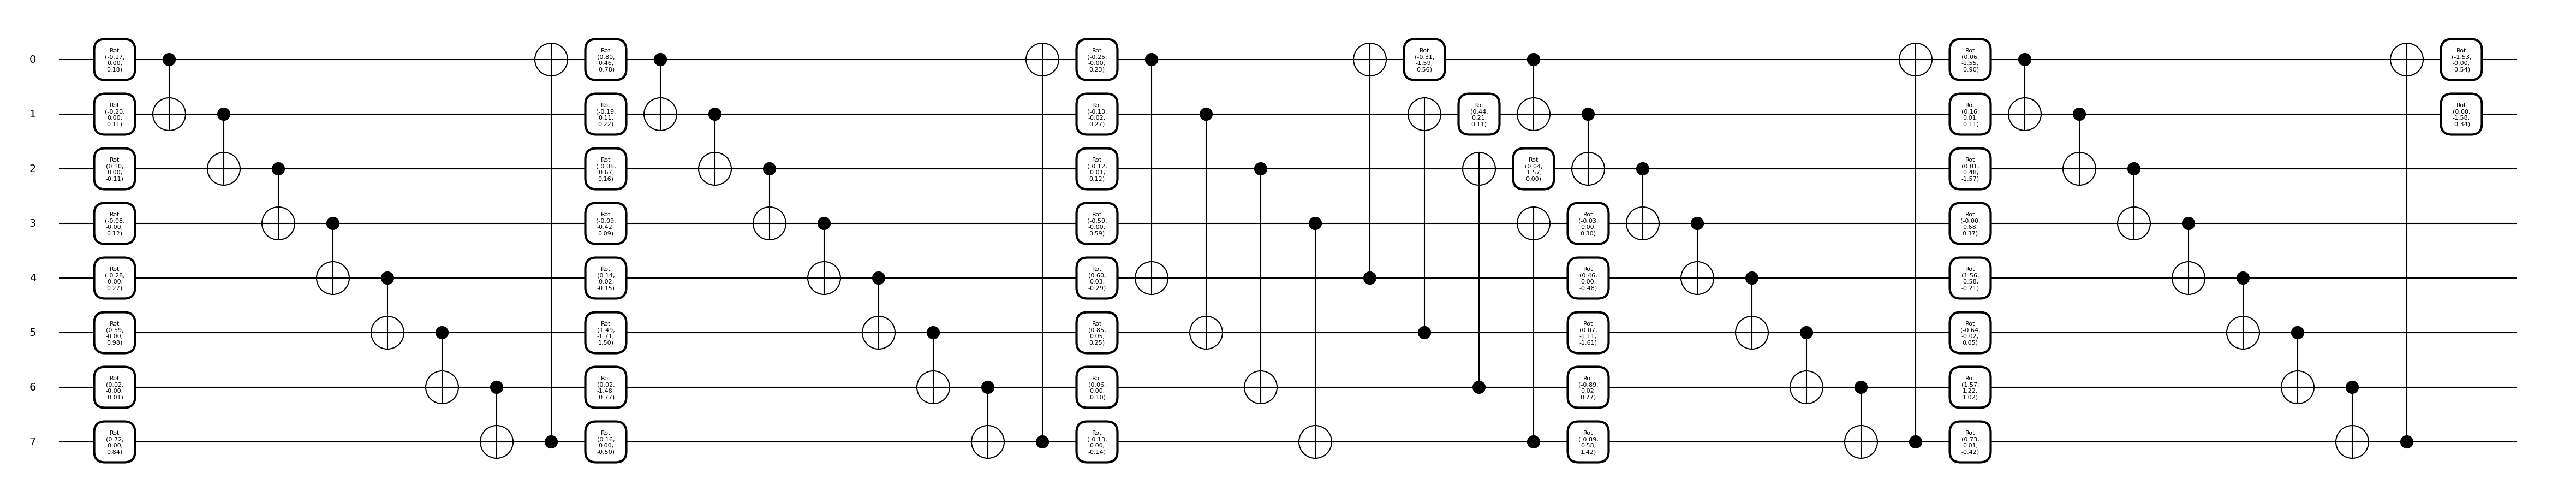

In [86]:
import json
import matplotlib.pyplot as plt

measurements = [0, 1]
main_params = model.params.detach().cpu().numpy()
final_rot_params = model.final_rot_params.detach().cpu().numpy()

@qml.qnode(dev, interface='torch')
def Classifier(main_params, final_rot_params):
    # Sandwich 구조
    qml.StronglyEntanglingLayers(main_params, wires=range(n_qubits), ranges=[1, 1, 4, 1, 1])

    # Final Rotation
    qml.Rot(*final_rot_params[0], wires=0)
    qml.Rot(*final_rot_params[1], wires=1)

qasm_data = qml.to_openqasm(Classifier, measure_all=False)(main_params, final_rot_params)

file_name = "./submission_lowest_loss.json"
with open(file_name, "w") as f:
    json.dump({ "qasm": qasm_data, "measurements": measurements }, f)

print(f"✅ Submission created: {file_name}")
print(f"✅ Final Model Stats -> Loss: {best_loss:.4f}, Acc: {best_acc}")

# 시각화
qml.draw_mpl(Classifier, level=2, decimals=2)(main_params, final_rot_params)
plt.show()

In [87]:
from google.colab import files
files.download(f'{file_name}')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>